In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn, functional as F

In [2]:
path = Path('../../data/large')

In [3]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0][:100].astype(float)
bestKnow_sum_constraints = pd.read_csv(path/'Best_Know1SumCV.csv', header=None).values[0][:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

In [4]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel()

In [6]:
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainer, model=model, window=nn_window)
speed_metric = partial(SpeedMetric, threadhold=0.1)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[nn_trainer],
                   metrics=[speed_metric, ModifiedOfflineError, ModifiedOfflineErrorContraints],
                   optimal_fitness_values=bestKnow, optimal_sum_constraints=bestKnow_sum_constraints)
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 00:38


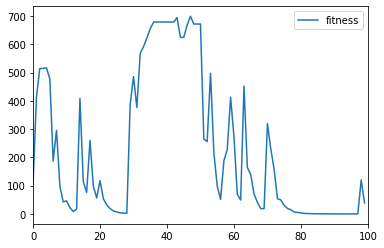

In [7]:
opt.run(total_generations)

In [16]:
opt.modified_offline_error

ModifiedOfflineError: 3.3474

In [17]:
opt.modified_offline_error_contraints

ModifiedOfflineErrorContraints: 32.7498

In [18]:
opt.speed_metric

SpeedMetric: 0.1400

In [19]:
opt.speed_metric.speeds

array([ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1., 392.,   8.,  40.,   8.,
        40.,   8.,  40.,   8.,  40.,   8.,  40.,   8.,  40.,   8.,  -1.,
        -1.])

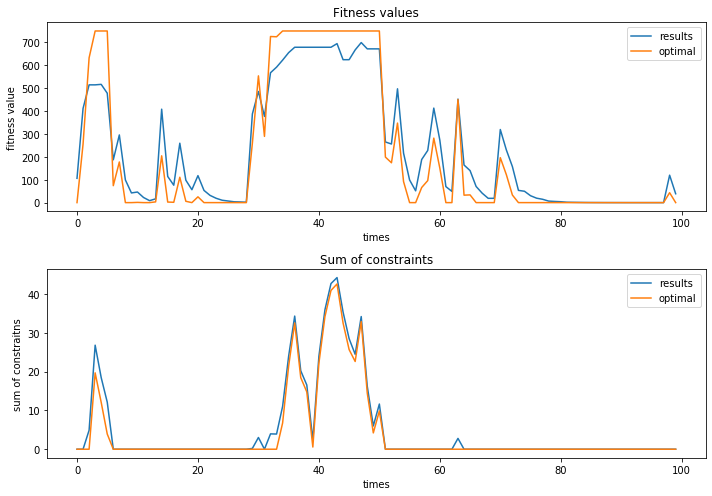

In [11]:
opt.recorder.plot();

In [12]:
pred = opt.nn_trainer.get_next_best()
pred

tensor([-0.3031, -0.4554, -0.5646, -0.7160, -0.5159, -0.1602, -0.6462, -0.8438,
        -1.3327, -0.7862, -0.8594, -0.5179, -0.3055, -1.0039, -1.1155, -0.9718,
        -1.3238, -0.0558, -0.4932, -1.1775, -0.6181, -1.1188, -0.7949, -1.3185,
        -0.6981, -0.9318, -0.0288, -1.0614, -0.9967, -0.8144])

In [13]:
fitness_func(opt.best, 0, 0), fitness_func(pred, 0, 0)

(38.78917, tensor(20.7719))

In [14]:
constraint_func(opt.best, ab, opt.time-1), constraint_func(pred, ab, opt.time-1)

(-17.170478969544405, tensor(-21.3574))

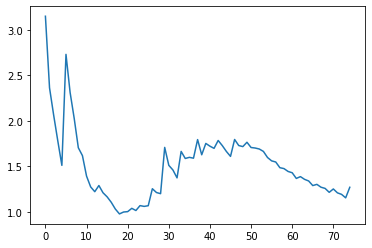

In [15]:
plt.plot(opt.nn_trainer.train_losses)